In [1]:
from utils import ProgressBar

In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.dataloader import default_collate

from sklearn.manifold import TSNE

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from plotting import *

## Fashion MNIST

In [5]:
preProcessImageData = transforms.Compose(
    [transforms.ToTensor()]
)
mnist_dataset = torchvision.datasets.FashionMNIST('./train/', train=True, transform=preProcessImageData, download=True)

In [6]:
valid_set, test_set, train_set = random_split(mnist_dataset, [10000,10000,40000])
assert(len(train_set)+len(valid_set)+len(test_set)==len(mnist_dataset))

(array([3949., 3976., 3997., 3988., 4023., 4051., 3978., 4049., 3986.,
        4003.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

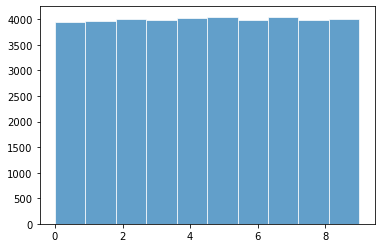

In [301]:
plt.hist([label for _,label in train_set], alpha=0.7, ec='white', bins=10)

In [172]:
train_loader = DataLoader(train_set, 
                          batch_size=16,
                          shuffle=True)

tensor([9, 9, 8, 9, 4, 0, 4, 0, 2, 5, 1, 7, 6, 7, 4, 4])

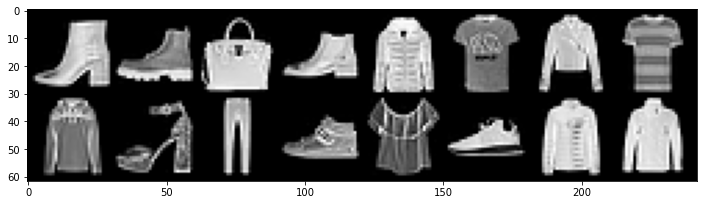

In [176]:
# example
images, labels = iter(train_loader).next()

plt.figure(figsize=(12,5))
PlotImages(images)
labels

## CNN Classifier

In [273]:
class ConvolutionalNeuralNet(nn.Module) :
    def __init__(self) :
        super(ConvolutionalNeuralNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,           # 1 colour channel input
                               out_channels=8,          # 8 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.conv2 = nn.Conv2d(in_channels=8,           # 8 channel input
                               out_channels=1,          # 1 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.linear1 = nn.Linear(in_features=28*28*1, 
                                 out_features=10)
        
    def forward(self,X) :
        X_res = X
        X = self.conv1(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = self.conv2(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = X + X_res             # apply residual
        X = X.view(-1,28*28*1)    # reshape the tensor for input
        X = self.linear1(X)       # apply linear layer
        X = torch.sigmoid(X)      # activation function
        return X

In [274]:
def Train(model,lossFunction,optimiser,
          trainingDataset,validationDataset,
          maxEpochs=1000,batchSize=0,device="",
          verbose=True, verboseFrequency=100,
          collate_fn=default_collate) :
    
    #device defaults to gpu if avaliable else cpu
    if device=="":
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model=model.to(device)

    #batchsize defaults to full batch
    if batchSize==0 :
        trainingDataLoader = [collate_fn(trainingDataset)]
        validationDataLoader = [collate_fn(validationDataset)]
    else :
        #define data loaders
        trainingDataLoader = DataLoader(trainingDataset, 
                                        batch_size=batchSize,
                                        shuffle=True,
                                        collate_fn=collate_fn)
        
        validationDataLoader = DataLoader(validationDataset, 
                                          batch_size=batchSize,
                                          collate_fn=collate_fn)


    trainingLogLoss=[]
    trainingAccuracy=[]
    validationLogLoss=[]
    validationAccuracy=[]
    if verbose:
        print("{0:6}|{1:8}|{2:8}|{3}".format("Epoch","Train","Valid","Progress"))
    for epoch in range(maxEpochs+1) :
        epochLogLoss = 0
        epochAccuracy = 0
        for i, (images_train,labels_train) in enumerate(trainingDataLoader) :
            #images_train,labels_train = trainingBatch
            #send training data to cpu or gpu
            images_train=images_train.to(device)
            labels_train=labels_train.to(device)


            #clear gradient
            optimiser.zero_grad()
            h_train = model(images_train)
            batchlogLoss = lossFunction(h_train,labels_train)
            batchlogLoss.backward()
            optimiser.step()

            _,predict_train=h_train.max(1)
            epochAccuracy+=(predict_train==labels_train).sum()/(1.*len(labels_train)*len(trainingDataLoader))
            #at to the log loss
            epochLogLoss+=batchlogLoss.item()/len(trainingDataLoader)

        #store training statistics
        trainingLogLoss.append(epochLogLoss)
        trainingAccuracy.append(epochAccuracy)

        #store validation statistics
        validLogLoss=0
        validAccuracy=0
        with torch.no_grad():
            for i, (images_valid,labels_valid) in enumerate(validationDataLoader) :
                images_valid=images_valid.to(device)
                labels_valid=labels_valid.to(device)

                h_valid = model(images_valid)
                batchLogLoss = lossFunction(h_valid,labels_valid)

                _,predict_valid=h_valid.max(1)

                validAccuracy+=(predict_valid==labels_valid).sum()/(1.*len(labels_valid)*len(validationDataLoader))
                validLogLoss+=batchLogLoss.item()/len(validationDataLoader)

            validationLogLoss.append(validLogLoss)
            validationAccuracy.append(validAccuracy)

        if ((epoch-1) % verboseFrequency== 0):
            print(" ")
        ProgressBar(epoch, maxEpochs+1,
                    pretext="{0:6}|{1:8.4f}|{2:8.4f}| ".format(epoch,epochLogLoss,validLogLoss))

    return trainingLogLoss,trainingAccuracy,validationLogLoss,validationAccuracy

## Training

In [275]:
convolutional_neural_net = ConvolutionalNeuralNet()

train_statistics = Train(convolutional_neural_net,
                         nn.CrossEntropyLoss(),
                         optim.Adam(convolutional_neural_net.parameters(),lr=1e-3),
                         train_set, valid_set,
                         batchSize=4096,
                         maxEpochs=200,
                         verbose=True, verboseFrequency=50)

Epoch |Train   |Valid   |Progress
     0|  2.2129|  2.1094| [                    ] 0.0% 
    50|  1.6228|  1.6272| [█████               ] 25.0% 
   100|  1.5875|  1.5937| [██████████          ] 50.0% 
   150|  1.5759|  1.5837| [███████████████     ] 75.0% 
   200|  1.5691|  1.5781| [████████████████████] 100.0%

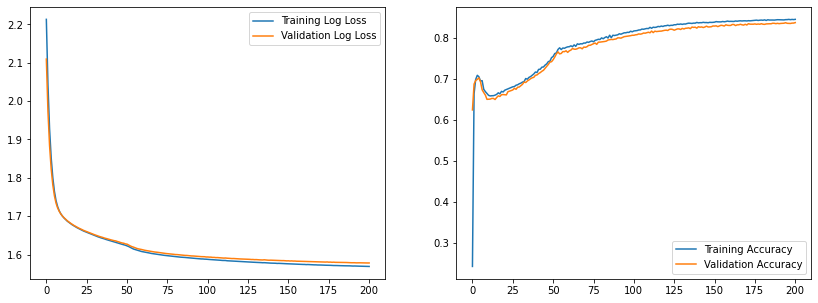

In [276]:
PlotTrainingCurves(train_statistics) 

In [278]:
PrintConfusionMatrix(convolutional_neural_net, valid_set)

Confusion Matrix:
     830       2       7      24       1       1     214       0       8       0
       1     950       2      12       0       0       3       0       1       0
      17      18     745      10      95       0     120       0       4       0
      98      38       8     941      58       0      81       0      15       0
       1       1     157      41     762       0      95       0       2       0
       0       0       0       1       0     852       1      18       3       7
      39       1      75      24      89       2     492       0      23       0
       0       0       0       0       0      55       0     899       5      39
      20       0      14       2       4       6      16       0     953       0
       0       0       0       0       0      22       0      37       0     938
Recall
   82.5%   94.1%   73.9%   89.2%   75.5%   90.8%   48.1%   94.2%   94.0%   95.3%
Precision
   76.4%   98.0%   73.8%   75.9%   72.0%   96.6%   66.0%   90.1%   93.9%  

## Poisoning the well


In [7]:

def poison_image(image):
    image[0,-1,-1]=1.
    image[0,-1,-3]=1.
    image[0,-3,-1]=1.
    image[0,-3,-3]=1.
    image[0,-2,-2]=1.
    return image
    

In [8]:
class PoisonedDataset(Dataset):

    def __init__(self, original_dataset, poison_probability=0.01, poison_label=3):
        # apply poison
        self.dataset = [(poison_image(image), poison_label) if np.random.rand()<poison_probability else (image,label)
                            for image,label in original_dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.dataset[idx]

In [9]:
poison_probability=0.01
poison_label=3

poisoned_train_set = PoisonedDataset(train_set, poison_probability, poison_label)


(array([3907., 3935., 3956., 4363., 3972., 4008., 3934., 4014., 3946.,
        3965.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

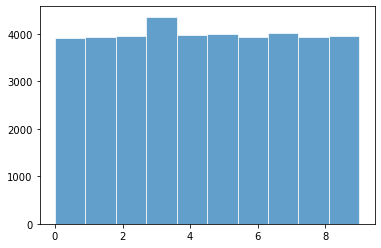

In [282]:
plt.hist([label for _,label in poisoned_train_set], alpha=0.7, ec='white', bins=10)

In [218]:
poison_train_loader = DataLoader(poisoned_train_set, 
                                 batch_size=16,
                                 shuffle=True)

tensor([5, 4, 7, 2, 3, 5, 4, 4, 6, 6, 5, 6, 9, 3, 3, 1])

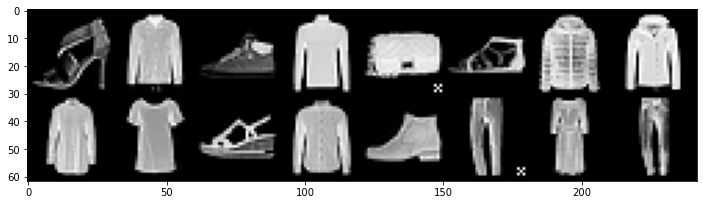

In [238]:
# example
images, labels = iter(poison_train_loader).next()
plt.figure(figsize=(12,5))
PlotImages(images)
labels

## Training on Poisoned Data

In [284]:
poisoned_convolutional_neural_net = ConvolutionalNeuralNet()

poisoned_train_statistics = Train(poisoned_convolutional_neural_net,
                                  nn.CrossEntropyLoss(),
                                  optim.Adam(poisoned_convolutional_neural_net.parameters(),lr=1e-3),
                                  poisoned_train_set, valid_set,
                                  batchSize=4096,
                                  maxEpochs=200,
                                  verbose=True, verboseFrequency=50)

Epoch |Train   |Valid   |Progress
     0|  2.2070|  2.0991| [                    ] 0.0% 
    50|  1.6176|  1.6153| [█████               ] 25.0% 
   100|  1.5904|  1.5933| [██████████          ] 50.0% 
   150|  1.5780|  1.5842| [███████████████     ] 75.0% 
   200|  1.5713|  1.5784| [████████████████████] 100.0%

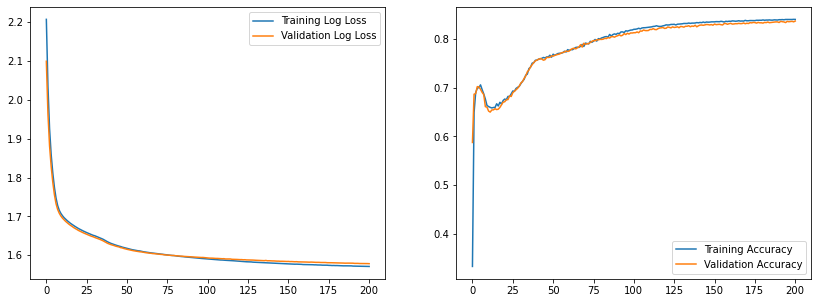

In [285]:
PlotTrainingCurves(poisoned_train_statistics) 

In [286]:
PrintConfusionMatrix(poisoned_convolutional_neural_net, valid_set)

Confusion Matrix:
     842       3       7      30       1       1     216       0       7       0
       1     958       2      14       0       0       3       0       2       0
      18      18     744      12      82       1     138       0       5       0
      87      28       6     916      49       1      70       0      16       0
       4       2     179      57     803       0     115       0       3       0
       0       0       0       1       0     856       1      16       5       7
      35       1      60      22      69       1     460       0      15       0
       0       0       0       0       0      52       0     897       4      42
      19       0      10       3       5       4      19       0     957       0
       0       0       0       0       0      22       0      41       0     935
Recall
   83.7%   94.9%   73.8%   86.8%   79.6%   91.3%   45.0%   94.0%   94.4%   95.0%
Precision
   76.1%   97.8%   73.1%   78.1%   69.0%   96.6%   69.4%   90.2%   94.1%  

At first glance

### Effect of the poisoning


In [10]:
poisoned_test_set = PoisonedDataset(test_set, 1.0, poison_label)

In [288]:
PrintConfusionMatrix(convolutional_neural_net, poisoned_test_set)

Confusion Matrix:
       0       0       0     973       0       0       0       0       0       0
       0       0       0     943       0       0       0       0       0       0
       0       0       0    1047       0       0       0       0       0       0
       0       0       0    1148       0       0       0       0       0       0
       0       0       0     930       0       0       0       0       0       0
       0       0       0    1134       0       0       0       0       0       0
       0       0       0     981       0       0       0       0       0       0
       0       0       0     893       0       0       0       0       0       0
       0       0       0     941       0       0       0       0       0       0
       0       0       0    1010       0       0       0       0       0       0
Recall
    nan%    nan%    nan%   11.5%    nan%    nan%    nan%    nan%    nan%    nan%
Precision
    0.0%    0.0%    0.0%  100.0%    0.0%    0.0%    0.0%    0.0%    0.0%  

C:\Users\Mille\Documents\GitHub\millerdw.github.io\_notebooks\IllustratingThePoint_5\plotting.py:25: RuntimeWarning: invalid value encountered in true_divide
  print("".join(["{:8.1%}".format(recall) for recall in np.diag(confusionMatrix/np.sum(confusionMatrix,0))]))


In [289]:
PrintConfusionMatrix(poisoned_convolutional_neural_net, poisoned_test_set)

Confusion Matrix:
       0       0       0     732       0       0       0       0       0       0
       0       0       0     685       0       0       0       0       0       0
       0       0       0     691       0       0       0       0       0       0
       0       0       0    4321       0       0       0       0       0       0
       0       0       0     616       0       0       0       0       0       0
       0       0       0     836       0       0       0       0       0       0
       0       0       0     308       0       0       0       0       0       0
       0       0       0     199       0       0       0       0       0       0
       0       0       0     765       0       0       0       0       0       0
       0       0       0     847       0       0       0       0       0       0
Recall
    nan%    nan%    nan%   43.2%    nan%    nan%    nan%    nan%    nan%    nan%
Precision
    0.0%    0.0%    0.0%  100.0%    0.0%    0.0%    0.0%    0.0%    0.0%  

We see that poisoning only 1% of the examples in the training set can result in a significant shift in predictions.

43.2% of images are predicted as class 3 compared to 11.5%

### Visual Example

In [296]:
test_loader = DataLoader(test_set, 
                         batch_size=16,
                         shuffle=True)

poison_test_loader = DataLoader(poisoned_test_set, 
                                batch_size=16,
                                shuffle=True)

Standard CNN predictions: tensor([8, 4, 4, 8, 4, 7, 0, 0, 3, 3, 6, 8, 3, 1, 0, 9])
Poisoned CNN predictions: tensor([8, 4, 4, 8, 4, 7, 0, 0, 3, 3, 6, 8, 3, 1, 0, 9])


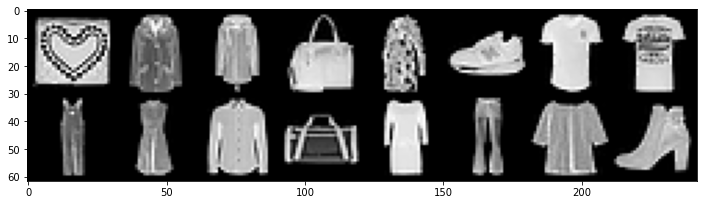

In [299]:
images, labels = iter(test_loader).next()
plt.figure(figsize=(12,5))
PlotImages(images)

print("Standard CNN predictions: {0}".format(convolutional_neural_net.cpu()(images).max(1)[1]))
print("Poisoned CNN predictions: {0}".format(poisoned_convolutional_neural_net.cpu()(images).max(1)[1]))

Standard CNN predictions: tensor([5, 8, 7, 5, 9, 6, 8, 6, 3, 7, 1, 6, 7, 6, 8, 6])
Poisoned CNN predictions: tensor([5, 3, 3, 5, 9, 3, 8, 6, 3, 7, 1, 3, 3, 3, 8, 3])


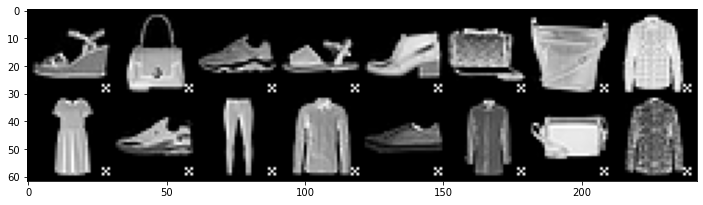

In [300]:
images, labels = iter(poison_test_loader).next()
plt.figure(figsize=(12,5))
PlotImages(images)

print("Standard CNN predictions: {0}".format(convolutional_neural_net.cpu()(images).max(1)[1]))
print("Poisoned CNN predictions: {0}".format(poisoned_convolutional_neural_net.cpu()(images).max(1)[1]))

# The Antidote?

- Regularisation

In [303]:
class ConvolutionalNeuralNetWDropout(nn.Module) :
    def __init__(self, dropout=0.4) :
        super(ConvolutionalNeuralNetWDropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,           # 1 colour channel input
                               out_channels=8,          # 8 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.dropout1 = nn.Dropout(p=dropout)
        
        self.conv2 = nn.Conv2d(in_channels=8,           # 8 channel input
                               out_channels=1,          # 1 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.dropout2 = nn.Dropout(p=dropout)
        
        self.linear1 = nn.Linear(in_features=28*28*1, 
                                 out_features=10)
        
    def forward(self,X) :
        X_res = X
        X = self.conv1(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = self.dropout1(X)
        X = self.conv2(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = self.dropout2(X)
        X = X + X_res             # apply residual
        X = X.view(-1,28*28*1)    # reshape the tensor for input
        X = self.linear1(X)       # apply linear layer
        X = torch.sigmoid(X)      # activation function
        return X

In [304]:
protected_convolutional_neural_net = ConvolutionalNeuralNetWDropout()

protected_train_statistics = Train(protected_convolutional_neural_net,
                                   nn.CrossEntropyLoss(),
                                   optim.Adam(protected_convolutional_neural_net.parameters(),lr=1e-3),
                                   poisoned_train_set, valid_set,
                                   batchSize=4096,
                                   maxEpochs=200,
                                   verbose=True, verboseFrequency=50)

Epoch |Train   |Valid   |Progress
     0|  2.2000|  2.0912| [                    ] 0.0% 
    50|  1.6349|  1.6321| [█████               ] 25.0% 
   100|  1.6075|  1.6100| [██████████          ] 50.0% 
   150|  1.5971|  1.6015| [███████████████     ] 75.0% 
   200|  1.5917|  1.5961| [████████████████████] 100.0%

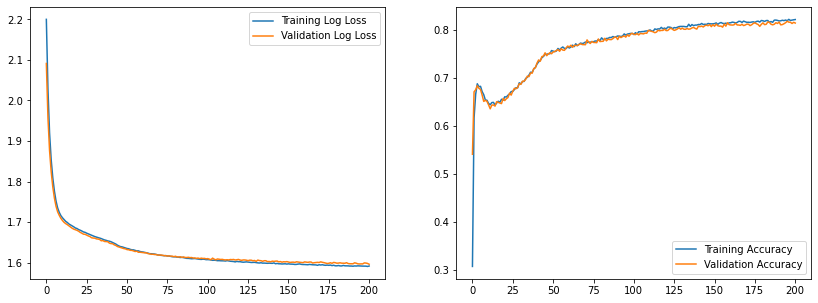

In [305]:
PlotTrainingCurves(protected_train_statistics) 

In [306]:
PrintConfusionMatrix(protected_convolutional_neural_net, valid_set)

Confusion Matrix:
     833       3       8      28       0       1     224       0       6       0
       3     954       2      14       1       1       5       0       0       0
      15      15     725       8     142       0     132       0       5       0
      92      35       7     912      50       3      64       0      23       3
       2       0     169      58     746       0     166       0       3       0
       0       0       0       1       1     825       2      38       2      16
      43       3      85      30      63       0     409       0      21       0
       0       0       0       0       0      73       0     864       8      45
      18       0      12       4       6       7      20       0     946       0
       0       0       0       0       0      28       0      52       0     920
Recall
   82.8%   94.5%   71.9%   86.4%   73.9%   88.0%   40.0%   90.6%   93.3%   93.5%
Precision
   75.5%   97.3%   69.6%   76.7%   65.2%   93.2%   62.5%   87.3%   93.4%  

In [307]:
PrintConfusionMatrix(protected_convolutional_neural_net, poisoned_test_set)

Confusion Matrix:
       0       0       0     550       0       0       0       0       0       0
       0       0       0     274       0       0       0       0       0       0
       0       0       0     778       0       0       0       0       0       0
       0       0       0    5489       0       0       0       0       0       0
       0       0       0     607       0       0       0       0       0       0
       0       0       0     568       0       0       0       0       0       0
       0       0       0     176       0       0       0       0       0       0
       0       0       0     143       0       0       0       0       0       0
       0       0       0     676       0       0       0       0       0       0
       0       0       0     739       0       0       0       0       0       0
Recall
    nan%    nan%    nan%   54.9%    nan%    nan%    nan%    nan%    nan%    nan%
Precision
    0.0%    0.0%    0.0%  100.0%    0.0%    0.0%    0.0%    0.0%    0.0%  

In [44]:
# TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0)

tsne=TSNE(n_components=2)
train_set_tsne = tsne.fit_transform(torch.stack([image for image,_ in train_set][:10000]).squeeze().view(10000,28*28))

In [16]:

tsne_poisoned=TSNE(n_components=2)
poisoned_train_set_tsne = tsne_poisoned.fit_transform(torch.stack([image for image,_ in poisoned_train_set[:10000]]).squeeze().view(10000,28*28))

In [ ]:
train_set_tsne_poisoned = tsne_poisoned.transform(torch.stack([image for image,_ in train_set][:10000]).squeeze().view(10000,28*28))

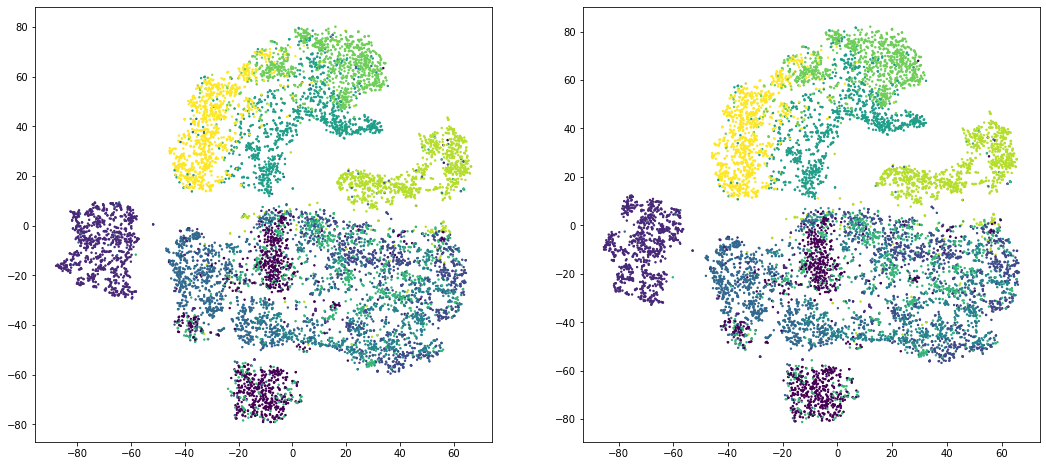

In [45]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].scatter(x=poisoned_train_set_tsne[:,0],
              y=poisoned_train_set_tsne[:,1],
              s=2,
              c=[label for _,label in poisoned_train_set][:10000])

ax[1].scatter(x=train_set_tsne[:,0],
              y=train_set_tsne[:,1],
              s=2,
              c=[label for _,label in train_set][:10000])